Time-of-Day MA(7) — MAE: 0.525, RMSE: 0.720


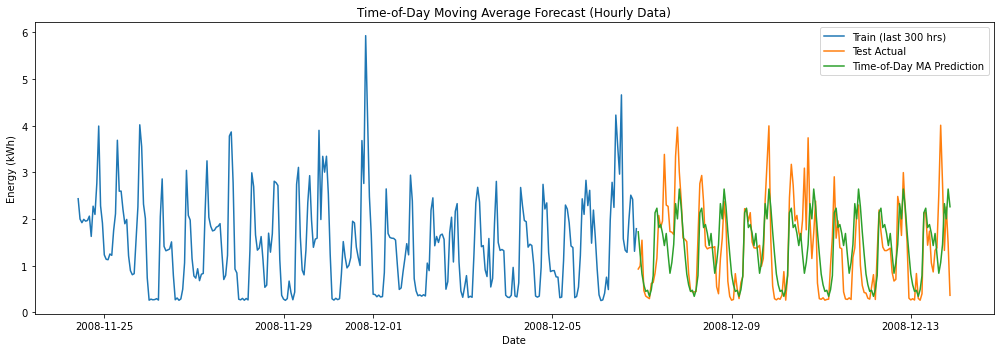

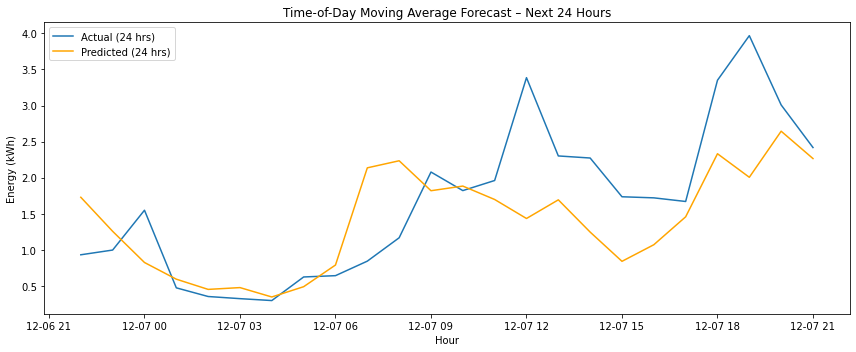

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load hourly file
df = pd.read_csv("household_power_consumption_hourly.csv")

# Parse datetime column
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.sort_values("DateTime")

# Set index
df = df.set_index("DateTime")

# Ensure hourly frequency
y = df["Global_active_power"].asfreq("H").interpolate(limit_direction="both")

# Extract hour of day (0–23)
hour = y.index.hour

# Last 7 days (7*24 hours) for testing
h = 24 * 7
train = y.iloc[:-h]
test = y.iloc[-h:]

# TIME-OF-DAY MOVING AVERAGE MODEL
window_days = 7
ma_pred = []

for t in test.index:
    hour_of_day = t.hour

    # Select past values from the same hour
    past_same_hour = train[train.index.hour == hour_of_day].tail(window_days)

    # If not enough data, average available values
    pred = past_same_hour.mean()

    ma_pred.append(pred)

# Predictions as series
ma_pred = pd.Series(ma_pred, index=test.index)

# Remove NaNs if any
mask = ~(test.isna() | ma_pred.isna())
test_clean = test[mask]
pred_clean = ma_pred[mask]

# Metrics
mae = mean_absolute_error(test_clean, pred_clean)
rmse = np.sqrt(mean_squared_error(test_clean, pred_clean))

print(f"Time-of-Day MA({window_days}) — MAE: {mae:.3f}, RMSE: {rmse:.3f}")

# Plot
plt.figure(figsize=(14,5))
plt.plot(train[-300:].index, train[-300:].values, label="Train (last 300 hrs)")
plt.plot(test.index, test.values, label="Test Actual")
plt.plot(ma_pred.index, ma_pred.values, label="Time-of-Day MA Prediction")
plt.title("Time-of-Day Moving Average Forecast (Hourly Data)")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

# Select the next 24 actual and predicted values
test_24 = test.iloc[:24]
pred_24 = ma_pred.iloc[:24]

plt.figure(figsize=(12,5))
plt.plot(test_24.index, test_24.values, label="Actual (24 hrs)")
plt.plot(pred_24.index, pred_24.values, label="Predicted (24 hrs)", color="orange")

plt.title("Time-of-Day Moving Average Forecast – Next 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.tight_layout()
plt.show()



